#Library

In [2]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
from pathlib import Path


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mothy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Prepare datasets**

In [3]:
df= pd.read_csv(r'../../data/train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])
df_alay = pd.read_csv('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/new_kamusalay.csv', names=['alay','cleaned'],encoding='latin-1')
stopwords_dict = pd.read_csv('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/stopwordbahasa.csv', names=['stopword'])

In [4]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [5]:
df.shape

(11000, 2)

#Check Data

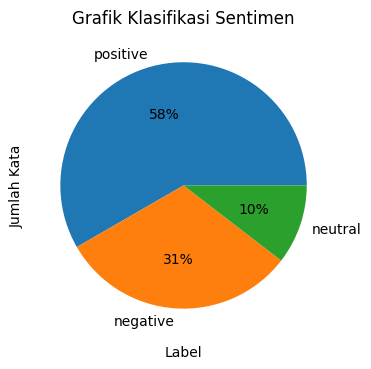

In [6]:
df["label"].value_counts().plot.pie(figsize=(7,4), autopct='%1.0f%%')
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.show()


In [7]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [12]:
def lowercase(text): # lowercase
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('RT',' ',text) # Remove every retweet symbol 
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_emoji(text):
    subs = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text_emo = subs.sub(r'',text)
    return text_emo

alay_dict = dict(zip(df_alay['alay'], df_alay['cleaned']))
def remove_alay(text):
    return ' '.join([alay_dict[word] if word in alay_dict else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopwords_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_unnecessary_char(text) #2
    text = remove_nonaplhanumeric(text) # 3
    text = remove_emoji(text) #4
    text = remove_alay(text) #5
    text = remove_stopword(text) #6
    text = stemming(text) #7
    return text

In [13]:
df['text_clean'] = df.text.apply(preprocess)

In [99]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...


#Sortir Data Berdasarkan 3 Sentimen

In [101]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


# **Feature Extraction**

In [102]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [103]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


# **Split Dataset For Training & Testing**

In [104]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# **Training (RNN)**

In [108]:
embed_dim = 200
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SimpleRNN(units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
adam=optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 78, 200)           2000000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                16960     
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,017,155
Trainable params: 2,017,155
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
880/880 [==============================] - 35s 37ms/step - loss: 0.6309 - accuracy: 0.7243 - val_loss: 0.5134 - val_accuracy: 0.8173
Epoch 2/30
880/880 [==============================] - 32s 36ms/step - loss: 0.3202 - accuracy: 0.8823 - val_loss: 0.4563 - val_accuracy: 0.8345
Epoch 3/30
880/

#Evaluation

In [109]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 1s 13ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       687
           1       0.68      0.57      0.62       223
           2       0.86      0.86      0.86      1290

    accuracy                           0.79      2200
   macro avg       0.75      0.72      0.73      2200
weighted avg       0.79      0.79      0.79      2200



#Cross Validation

In [110]:
kf = KFold(n_splits=5,random_state=2,shuffle=True)

accuracies = []

y = Y

embed_dim = 200
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    adam=optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_test, y_test), verbose=1)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/30
880/880 [==============================] - 35s 36ms/step - loss: 0.5960 - accuracy: 0.7499 - val_loss: 0.4532 - val_accuracy: 0.8264
Epoch 2/30
880/880 [==============================] - 32s 36ms/step - loss: 0.3206 - accuracy: 0.8805 - val_loss: 0.4526 - val_accuracy: 0.8259
Epoch 3/30
880/880 [==============================] - 32s 36ms/step - loss: 0.2124 - accuracy: 0.9207 - val_loss: 0.5328 - val_accuracy: 0.8264
Epoch 4/30
880/880 [==============================] - 32s 36ms/step - loss: 0.1673 - accuracy: 0.9377 - val_loss: 0.6009 - val_accuracy: 0.8318
Epoch 5/30
880/880 [==============================] - 32s 36ms/step - loss: 0.1327 - accuracy: 0.9516 - val_loss: 0.6036 - val_accuracy: 0.8268
Epoch 6/30
880/880 [==============================] - 32s 36ms/step - loss: 0.1128 - accuracy: 0.9552 - val_loss: 0.6917 - val_accuracy: 0.8145
Epoch 7/30
880/880 [==============================] - 32s 36ms/step - loss: 0.0970 - accuracy: 0.9642 - val_loss: 0.7012 - val_accuracy:

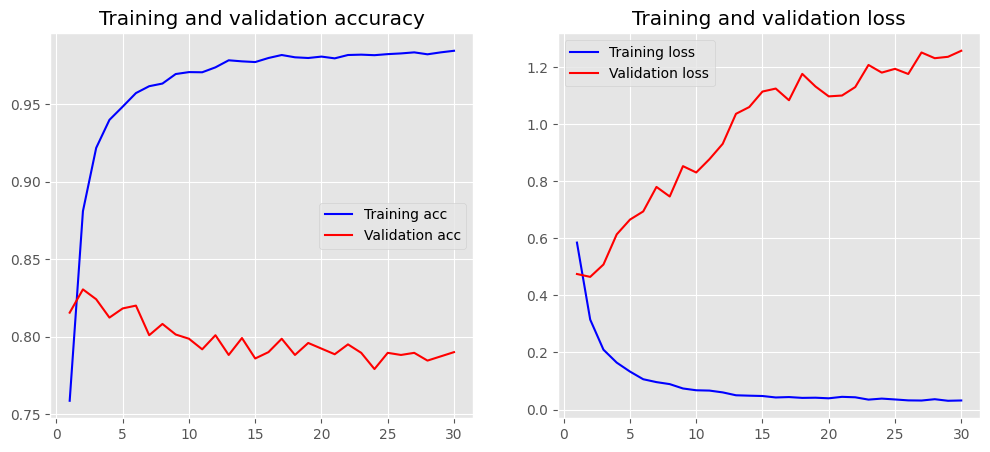

In [111]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [20]:
model.save('model_rnn.h5')
print('Model has created!')

Model has created!


#Testing Model

In [28]:
input_text = """ 
pintar memang anak satu itu
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_rnn.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 62ms/step
Text:  pintar anak
Sentiment:  positive
